In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

Load dataset and remove irrelevant fields (Loan_ID).

In [2]:
# ============================================================
# 1. Load dataset
# ============================================================

df = pd.read_csv("Loan payments data.csv")

# Drop useless ID column
df = df.drop(columns=["Loan_ID"])

Reclassify loan_status into a binary classification task.

In [3]:
# ============================================================
# 2. Binary classification label
# ------------------------------------------------------------
# Original loan_status may contain:
#   PAIDOFF
#   COLLECTION
#   COLLECTION_PAIDOFF
# We define:
#   PAIDOFF → 0
#   Others  → 1  (default / high-risk)
# ============================================================

df["loan_status_binary"] = (df["loan_status"] != "PAIDOFF").astype(int)

Parse date fields (effective_date, due_date, paid_off_time)

In [4]:
# ============================================================
# 3. Date preprocessing: parse effective_date, due_date, paid_off_time
# ============================================================

df["effective_date"] = pd.to_datetime(df["effective_date"])
df["due_date"] = pd.to_datetime(df["due_date"])
df["paid_off_time"] = pd.to_datetime(df["paid_off_time"], errors="coerce")
# errors="coerce" converts invalid date strings into NaT


Create key derived features (loan_duration, actual_pay_duration)

In [5]:
# ============================================================
# 4. Feature engineering from dates
# ============================================================

# loan duration: due_date - effective_date (days)
df["loan_duration"] = (df["due_date"] - df["effective_date"]).dt.days

# actual pay duration (NaN if not paid)
df["actual_pay_duration"] = (df["paid_off_time"] - df["effective_date"]).dt.days

# Missing actual_pay_duration means the loan was NOT fully paid
df["actual_pay_duration"] = df["actual_pay_duration"].fillna(0)

# Binary indicator whether paid_off_time exists
df["paid_off_missing"] = df["paid_off_time"].isna().astype(int)

Encode missing values in paid_off_time (indicator for repayment status)

In [6]:
# ============================================================
# 5. Handle missing values in past_due_days
# ------------------------------------------------------------
# past_due_days is missing when borrower paid on time:
#   NaN → 0 is correct meaning "no overdue"
# ============================================================

df["past_due_days"] = df["past_due_days"].fillna(0)

Handle missing values (past_due_days + other fields)

In [7]:
# ============================================================
# 6. Select feature columns
# ============================================================

numeric_cols = [
    "Principal",
    "terms",
    "past_due_days",
    "age",
    "loan_duration",
    "actual_pay_duration",
]

categorical_cols = ["education", "Gender"]

binary_cols = ["paid_off_missing"]  # already numeric & meaningful

# Construct feature DataFrame
X_raw = df[numeric_cols + categorical_cols + binary_cols].copy()
y = df["loan_status_binary"]

One-hot encoding

In [9]:
# ============================================================
# 7. One-hot encode categorical features
# ============================================================

X_cat = pd.get_dummies(X_raw[categorical_cols], drop_first=True)

# Combine:
X_processed = pd.concat([
    X_raw[numeric_cols],
    X_cat,
    X_raw[binary_cols]
], axis=1)

Numerical feature standardization

In [10]:
# ============================================================
# 8. Standardize numerical features
# ============================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)

Train/validation split

In [11]:
# ============================================================
# 9. Train/validation split
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


 Automatic calculation of class_weight (for use with BCEWithLogitsLoss)

In [12]:
# ============================================================
# 10. Convert to PyTorch tensors
# ============================================================

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)


# ============================================================
# 11. Compute class weights for imbalanced classification
# ============================================================

num_pos = (y_train == 1).sum().item()
num_neg = (y_train == 0).sum().item()
pos_weight_value = num_neg / num_pos  # > 1 → positive class rarer

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

print("Class counts:", num_neg, "(no default) /", num_pos, "(default)")
print("pos_weight for BCEWithLogitsLoss =", pos_weight.item())

# Now you can pass pos_weight into BCEWithLogitsLoss:
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("Preprocessing complete. X_train, X_val, y_train, y_val are ready.")
print("Input dim =", X_train.shape[1])

Class counts: 240 (no default) / 160 (default)
pos_weight for BCEWithLogitsLoss = 1.5
Preprocessing complete. X_train, X_val, y_train, y_val are ready.
Input dim = 11


A MLP Model with Switchable Activation Functions

In [13]:
import torch
import torch.nn as nn

# ============================================================
# This function returns the correct activation module
# based on a string name.
# ============================================================

def get_activation(name):
    """
    Return a PyTorch activation layer based on name.

    Options:
        linear      → no activation (Identity)
        sigmoid     → Sigmoid()
        relu        → ReLU()
        leaky_relu  → LeakyReLU(0.01)
    """
    name = name.lower()

    if name == "linear":
        return nn.Identity()
    elif name == "sigmoid":
        return nn.Sigmoid()
    elif name == "relu":
        return nn.ReLU()
    elif name == "leaky_relu":
        return nn.LeakyReLU(0.01)
    else:
        raise ValueError(f"Unknown activation name: {name}")


# ============================================================
# MLP model with selectable activation function
# ============================================================

class LoanMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], activation="relu"):
        super().__init__()

        act_layer = get_activation(activation)   # choose activation function

        layers = []
        in_dim = input_dim

        # Build hidden layers
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(act_layer)             # Add chosen activation
            in_dim = h

        # Output layer: single logit
        layers.append(nn.Linear(in_dim, 1))

        # Combine into a sequential network
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.net(x)
        return logits.view(-1)  # flatten to shape [batch_size]


print("LoanMLP class with selectable activation function is ready!")


LoanMLP class with selectable activation function is ready!


Create 4 models with different activation functions

In [14]:
input_dim = X_train.shape[1]

model_linear = LoanMLP(input_dim, activation="linear")
model_sigmoid = LoanMLP(input_dim, activation="sigmoid")
model_relu = LoanMLP(input_dim, activation="relu")
model_leakyrelu = LoanMLP(input_dim, activation="leaky_relu")


Below is a unified training loop for four models (Linear / Sigmoid / ReLU / Leaky ReLU), including:

- Automatic training for a specified number of epochs
- Automatic evaluation of loss, accuracy, F1-score, and ROC-AUC per epoch
- Saving the results of each activation function model into a dictionary
- Fully consistent training process → ensuring fair comparison across activation functions

In [15]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# ============================================================
# Training loop for one model
# ============================================================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * Xb.size(0)

    return running_loss / len(loader.dataset)


# ============================================================
# Evaluation loop for metrics
# ============================================================

def evaluate_model(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []

    criterion = nn.BCEWithLogitsLoss()

    running_loss = 0.0
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)

            logits = model(Xb)
            loss = criterion(logits, yb)

            running_loss += loss.item() * Xb.size(0)

            all_logits.append(logits.cpu())
            all_labels.append(yb.cpu())

    # concat predictions
    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Probabilities from logits
    probs = 1 / (1 + np.exp(-all_logits))
    preds = (probs >= 0.5).astype(int)

    # Metrics
    acc = accuracy_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)

    # AUC requires at least two classes present
    try:
        auc = roc_auc_score(all_labels, probs)
    except:
        auc = float("nan")

    avg_loss = running_loss / len(loader.dataset)

    return avg_loss, acc, f1, auc


# ============================================================
# Main function: train 4 models with different activations
# ============================================================

def train_all_models(activations, input_dim, train_loader, val_loader, pos_weight, num_epochs=20, lr=1e-3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = {}

    for act in activations:
        print(f"\n==============================")
        print(f"Training model with activation: {act}")
        print(f"==============================")

        # Build model
        model = LoanMLP(input_dim, activation=act).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

        history = {
            "train_loss": [],
            "val_loss": [],
            "val_acc": [],
            "val_f1": [],
            "val_auc": []
        }

        # Training loop
        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc, val_f1, val_auc = evaluate_model(model, val_loader, device)

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
            history["val_f1"].append(val_f1)
            history["val_auc"].append(val_auc)

            print(
                f"Epoch {epoch+1}/{num_epochs} | "
                f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
                f"acc={val_acc:.4f} | f1={val_f1:.4f} | auc={val_auc:.4f}"
            )

        # Save results
        results[act] = history

    return results


print("Unified training loop is ready.")


Unified training loop is ready.


In [18]:
from torch.utils.data import TensorDataset, DataLoader

# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [33]:
activations = ["linear", "sigmoid", "relu", "leaky_relu"]
input_dim = X_train.shape[1]

results = train_all_models(
    activations,
    input_dim,
    train_loader,
    val_loader,
    pos_weight=pos_weight,
    num_epochs=30,   # 建议30 epochs以上效果明显
    lr=1e-3
)
summary_table = summarize_activation_performance(results)
summary_table



Training model with activation: linear
Epoch 1/30 | train_loss=0.7839 | val_loss=0.6037 | acc=0.6200 | f1=0.6042 | auc=0.8000
Epoch 2/30 | train_loss=0.6842 | val_loss=0.5229 | acc=0.8100 | f1=0.7397 | auc=0.8133
Epoch 3/30 | train_loss=0.6170 | val_loss=0.4691 | acc=0.8800 | f1=0.8286 | auc=0.8300
Epoch 4/30 | train_loss=0.5730 | val_loss=0.4245 | acc=0.8600 | f1=0.7879 | auc=0.8458
Epoch 5/30 | train_loss=0.5442 | val_loss=0.3938 | acc=0.8600 | f1=0.7879 | auc=0.8567
Epoch 6/30 | train_loss=0.5228 | val_loss=0.3715 | acc=0.8800 | f1=0.8235 | auc=0.8688
Epoch 7/30 | train_loss=0.5072 | val_loss=0.3525 | acc=0.8800 | f1=0.8235 | auc=0.8833
Epoch 8/30 | train_loss=0.4885 | val_loss=0.3406 | acc=0.8800 | f1=0.8235 | auc=0.8962
Epoch 9/30 | train_loss=0.4743 | val_loss=0.3356 | acc=0.8800 | f1=0.8235 | auc=0.8996
Epoch 10/30 | train_loss=0.4636 | val_loss=0.3367 | acc=0.8800 | f1=0.8235 | auc=0.8992
Epoch 11/30 | train_loss=0.4501 | val_loss=0.3305 | acc=0.8900 | f1=0.8406 | auc=0.9046
E

,Activation,Final Val Loss,Final Val Accuracy,Final Val F1,Final Val AUC
0,linear,0.237722,0.91,0.873239,0.969167
2,relu,0.270992,0.91,0.873239,0.940833
3,leaky_relu,0.287337,0.90,0.861111,0.925000
1,sigmoid,0.426633,0.88,0.823529,0.856667


Plot training loss and AUC curves for all activations.

Plot functions ready: plot_loss_curves(results), plot_auc_curves(results)


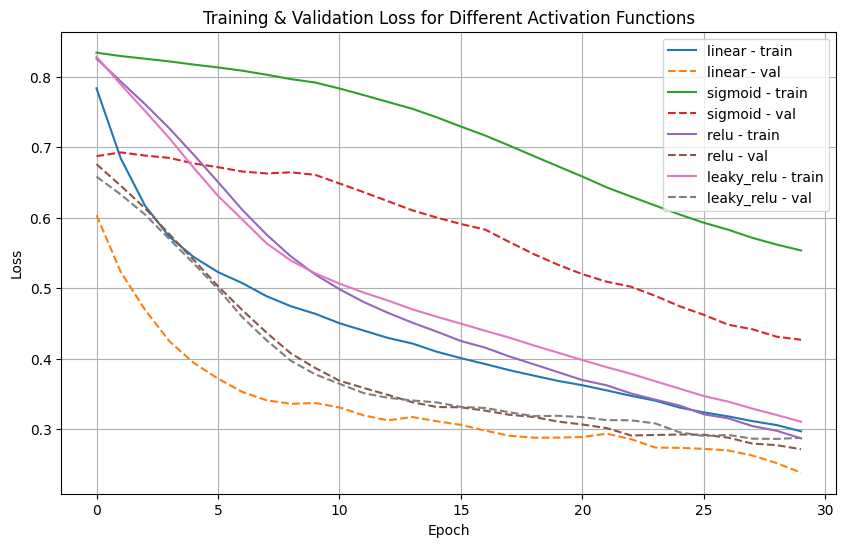

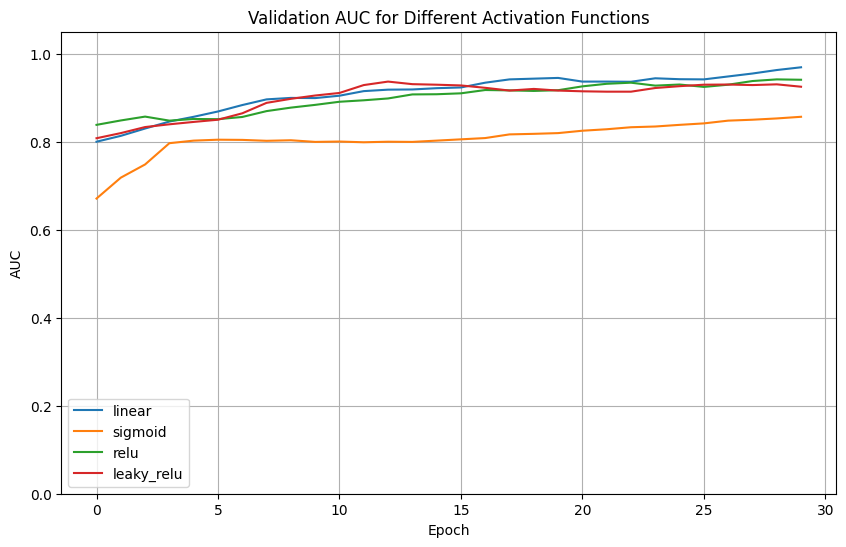

In [34]:
import matplotlib.pyplot as plt

# ============================================================
# Plot training & validation loss for all activations
# ============================================================

def plot_loss_curves(results):
    plt.figure(figsize=(10,6))

    for act in results.keys():
        plt.plot(results[act]["train_loss"], label=f"{act} - train")
        plt.plot(results[act]["val_loss"], label=f"{act} - val", linestyle="--")

    plt.title("Training & Validation Loss for Different Activation Functions")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


# ============================================================
# Plot AUC curves for all activations
# ============================================================

def plot_auc_curves(results):
    plt.figure(figsize=(10,6))

    for act in results.keys():
        plt.plot(results[act]["val_auc"], label=f"{act}")

    plt.title("Validation AUC for Different Activation Functions")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.ylim(0.0, 1.05)
    plt.show()


print("Plot functions ready: plot_loss_curves(results), plot_auc_curves(results)")

plot_loss_curves(results)

plot_auc_curves(results)

Plot the "predicted probability distribution histogram" for each activation function model.


Plotting histogram for activation: linear


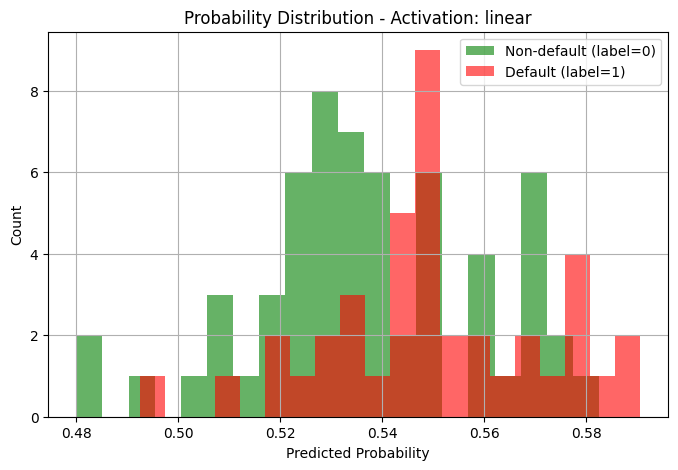


Plotting histogram for activation: sigmoid


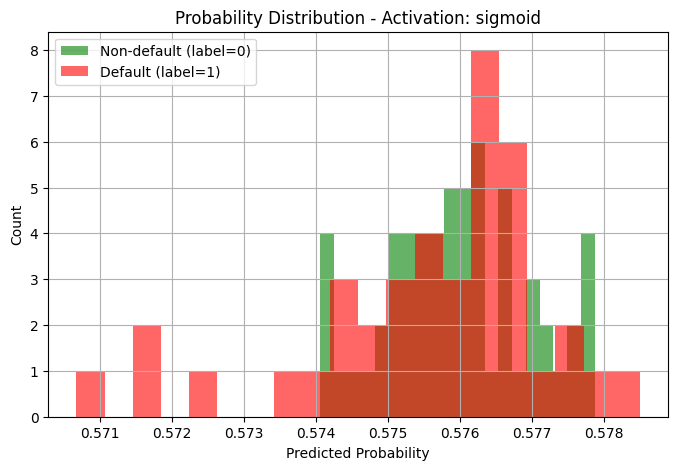


Plotting histogram for activation: relu


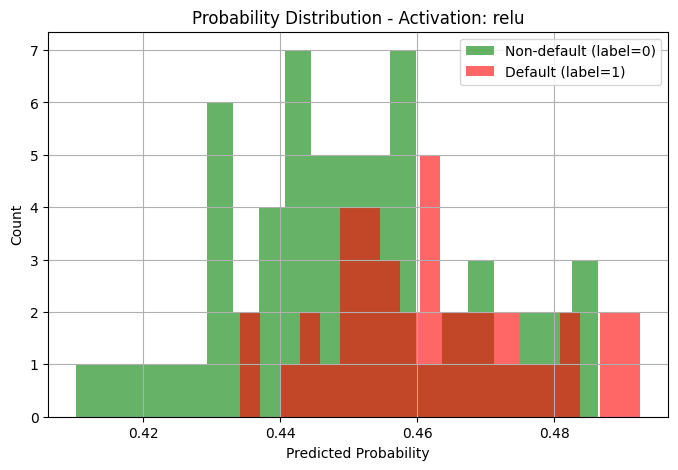


Plotting histogram for activation: leaky_relu


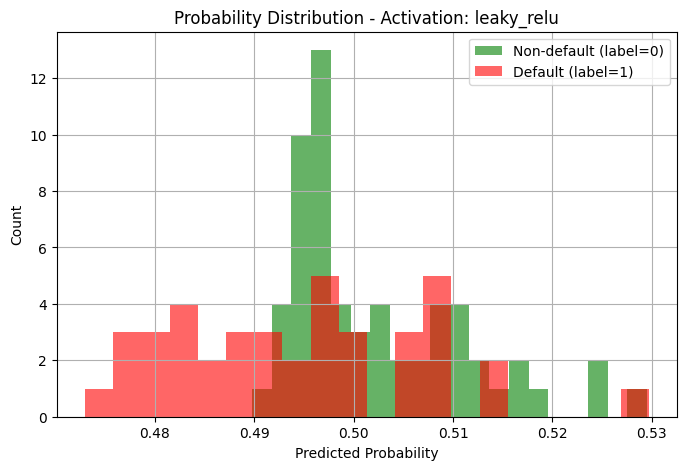

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Helper: get predicted probabilities from a trained model
# ============================================================

def get_probabilities(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            logits = model(Xb)

            all_logits.append(logits.cpu())
            all_labels.append(yb)

    all_logits = torch.cat(all_logits).numpy()
    all_labels = torch.cat(all_labels).numpy()

    probs = 1 / (1 + np.exp(-all_logits))

    return probs, all_labels


# ============================================================
# Plot histogram of probabilities for one model
# ============================================================

def plot_probability_histogram(model, val_loader, activation_name, device):
    probs, labels = get_probabilities(model, val_loader, device)

    plt.figure(figsize=(8,5))

    # mask by label
    probs_0 = probs[labels == 0]
    probs_1 = probs[labels == 1]

    plt.hist(probs_0, bins=20, alpha=0.6, label="Non-default (label=0)", color="green")
    plt.hist(probs_1, bins=20, alpha=0.6, label="Default (label=1)", color="red")

    plt.title(f"Probability Distribution - Activation: {activation_name}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()


# ============================================================
# Plot histograms for ALL activation functions
# ============================================================

def plot_all_probability_histograms(models_dict, val_loader):
    """
    models_dict should be:
    {
        "relu": trained_model,
        "sigmoid": trained_model,
        ...
    }
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for act, model in models_dict.items():
        print(f"\nPlotting histogram for activation: {act}")
        plot_probability_histogram(model, val_loader, act, device)
models = {
    "linear": model_linear,
    "sigmoid": model_sigmoid,
    "relu": model_relu,
    "leaky_relu": model_leakyrelu
}
plot_all_probability_histograms(models, val_loader)
